In [1]:
import pandas as pd 
import os
import numpy as np
import datetime
import numpy as np
import matplotlib.pyplot as plt
import wfdb
from wfdb import processing
import sklearn.gaussian_process as gp
import time
import pyts.approximation
import pickle
import gpflow
import tensorflow as tf
import csv
import sys
import GPy
import gpflow
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv ('uqvitalsignsdata/case01/uq_vsd_case01_trenddata.csv', error_bad_lines=False, index_col = False )

b'Skipping line 10: expected 55 fields, saw 56\nSkipping line 11: expected 55 fields, saw 56\nSkipping line 12: expected 55 fields, saw 56\nSkipping line 13: expected 55 fields, saw 56\nSkipping line 14: expected 55 fields, saw 56\nSkipping line 15: expected 55 fields, saw 56\nSkipping line 16: expected 55 fields, saw 56\nSkipping line 17: expected 55 fields, saw 56\nSkipping line 18: expected 55 fields, saw 56\nSkipping line 19: expected 55 fields, saw 56\nSkipping line 20: expected 55 fields, saw 56\nSkipping line 21: expected 55 fields, saw 56\nSkipping line 22: expected 55 fields, saw 57\nSkipping line 23: expected 55 fields, saw 57\nSkipping line 24: expected 55 fields, saw 57\nSkipping line 25: expected 55 fields, saw 57\nSkipping line 26: expected 55 fields, saw 57\nSkipping line 27: expected 55 fields, saw 57\nSkipping line 28: expected 55 fields, saw 57\nSkipping line 29: expected 55 fields, saw 57\nSkipping line 30: expected 55 fields, saw 57\nSkipping line 31: expected 55 fi

# Data Preprocessing

In [3]:
df.head()

,Time,RelativeTimeMilliseconds,Clock,HR,ST-II,Pulse,SpO2,Perf,etCO2,imCO2,...,Tidal Volume Exp (Spiro),Tidal Volume In (Spiro),Minute Volume Exp (Spiro),Minute Volume In (Spiro),Lung Compliance (Spiro),Airway Resistance (Spiro),Max Inspiratory Pressure (Spiro),Num Patient Alarms,Num Technical Alarms,Alarms...
0,00:00:00_000,0,17:33,55.0,NaN,55,100,0.4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING
1,00:00:01_000,1000,17:33,55.0,NaN,55,100,0.4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING
2,00:00:02_000,2000,17:33,55.0,NaN,54,100,0.4,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING
3,00:00:03_000,3000,17:33,55.0,NaN,54,100,0.3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING
4,00:00:04_000,4000,17:33,55.0,NaN,49,100,0.3,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,AGM ZERO RUNNING


In [4]:
df.isnull().sum()

Time                                   0
RelativeTimeMilliseconds               0
Clock                                  0
HR                                    80
ST-II                               7173
Pulse                                  0
SpO2                                   0
Perf                                   0
etCO2                                  0
imCO2                                  0
awRR                                   9
NBP (Sys)                              8
NBP (Dia)                            358
NBP (Mean)                           358
NBP (Pulse)                         7173
NBP (Time Remaining)                7173
ART (Sys)                           7173
ART (Dia)                           7173
ART (Mean)                          7173
etDES                               7173
inDES                               7173
etISO                               7173
inISO                               7173
etSEV                                 41
inSEV           

In [5]:
#Removing null values
df_removed_allnan = df.copy()
nan_val = float("NaN")
df_removed_allnan.replace("",nan_val,inplace=True)
df_removed_allnan.dropna(how="all",axis=1, inplace =True)

In [6]:
df_removed_allnan.head()

,Time,RelativeTimeMilliseconds,Clock,HR,Pulse,SpO2,Perf,etCO2,imCO2,awRR,...,inN2O,MAC,etO2,inO2,Tidal Volume,Minute Volume,RR,Num Patient Alarms,Num Technical Alarms,Alarms...
0,00:00:00_000,0,17:33,55.0,55,100,0.4,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
1,00:00:01_000,1000,17:33,55.0,55,100,0.4,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
2,00:00:02_000,2000,17:33,55.0,54,100,0.4,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
3,00:00:03_000,3000,17:33,55.0,54,100,0.3,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING
4,00:00:04_000,4000,17:33,55.0,49,100,0.3,0,0,NaN,...,0.0,0.0,98,98,0,0.0,0,0,1,AGM ZERO RUNNING


In [7]:
# getting the name of dropped columns from the main dataframe
df_cols = df.columns
cleaned_cols = df_removed_allnan.columns
list1 = df_cols.difference(cleaned_cols)
columns = list(df_removed_allnan)
print(len(list1),'Columns dropped')
print(df_cols.difference(cleaned_cols))

28 Columns dropped
Index(['ART (Dia)', 'ART (Mean)', 'ART (Sys)', 'Airway Resistance (Spiro)',
       'BIS', 'EMG', 'Lung Compliance (Spiro)',
       'Max Inspiratory Pressure (Spiro)', 'Minute Volume Exp (Spiro)',
       'Minute Volume In (Spiro)', 'NBP (Pulse)', 'NBP (Time Remaining)',
       'SQI', 'ST-II', 'Set I:E Ratio', 'Set Mechanical Ventilation',
       'Set PAWmax', 'Set PAWmin', 'Set PEEP', 'Set RR', 'Set Tidal Volume',
       'Temp', 'Tidal Volume Exp (Spiro)', 'Tidal Volume In (Spiro)', 'etDES',
       'etISO', 'inDES', 'inISO'],
      dtype='object')


In [8]:
#Dropping useless columns
df_removed_allnan = df_removed_allnan.drop("Time", 1)
df_removed_allnan = df_removed_allnan.drop("Clock", 1)
df_removed_allnan = df_removed_allnan.drop("Alarms...", 1)
df_removed_allnan = df_removed_allnan.drop("Num Patient Alarms", 1)
df_removed_allnan = df_removed_allnan.drop("Num Technical Alarms", 1)

In [9]:
df_removed_allnan.iloc[:,0:15]

,RelativeTimeMilliseconds,HR,Pulse,SpO2,Perf,etCO2,imCO2,awRR,NBP (Sys),NBP (Dia),NBP (Mean),etSEV,inSEV,etN2O,inN2O
0,0,55.0,55,100,0.4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,1000,55.0,55,100,0.4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2000,55.0,54,100,0.4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,3000,55.0,54,100,0.3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,4000,55.0,49,100,0.3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7168,7291000,NaN,51,98,1.2,38,1,9.0,106.0,63.0,72.0,0.45,0.05,0.0,0.0
7169,7292000,NaN,51,98,1.2,38,1,9.0,106.0,63.0,72.0,0.45,0.05,0.0,0.0
7170,7293000,NaN,51,98,1.2,38,1,9.0,106.0,63.0,72.0,0.45,0.05,0.0,0.0
7171,7294000,NaN,51,98,1.2,38,1,9.0,106.0,63.0,72.0,0.45,0.05,0.0,0.0


In [10]:
df_removed_allnan.iloc[:,15:21]

,MAC,etO2,inO2,Tidal Volume,Minute Volume,RR
0,0.0,98,98,0,0.0,0
1,0.0,98,98,0,0.0,0
2,0.0,98,98,0,0.0,0
3,0.0,98,98,0,0.0,0
4,0.0,98,98,0,0.0,0
...,...,...,...,...,...,...
7168,0.2,91,97,744,5.4,7
7169,0.2,91,97,744,5.4,7
7170,0.2,91,97,744,5.4,7
7171,0.2,91,97,5,5.0,7


In [11]:
df_removed_allnan.isnull().sum()

RelativeTimeMilliseconds      0
HR                           80
Pulse                         0
SpO2                          0
Perf                          0
etCO2                         0
imCO2                         0
awRR                          9
NBP (Sys)                     8
NBP (Dia)                   358
NBP (Mean)                  358
etSEV                        41
inSEV                        41
etN2O                         0
inN2O                         0
MAC                           0
etO2                          0
inO2                          0
Tidal Volume                  0
Minute Volume                 0
RR                            0
dtype: int64

In [12]:
# Train, Test & Validate split

df_train_validate, df_test = train_test_split(df_removed_allnan, test_size=0.25, random_state=1)
df_train, df_validate = train_test_split(df_train_validate, test_size=0.33, random_state=1)

In [13]:
#Sorting the datasets

df_train = df_train.sort_values('RelativeTimeMilliseconds')
df_test = df_test.sort_values('RelativeTimeMilliseconds')
df_validate = df_validate.sort_values('RelativeTimeMilliseconds')

In [14]:
df_train

,RelativeTimeMilliseconds,HR,Pulse,SpO2,Perf,etCO2,imCO2,awRR,NBP (Sys),NBP (Dia),...,etSEV,inSEV,etN2O,inN2O,MAC,etO2,inO2,Tidal Volume,Minute Volume,RR
0,0,55.0,55,100,0.4,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,98,98,0,0.0,0
2,2000,55.0,54,100,0.4,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,98,98,0,0.0,0
3,3000,55.0,54,100,0.3,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,98,98,0,0.0,0
6,6000,55.0,42,100,0.1,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,98,98,0,0.0,0
9,88000,61.0,52,100,0.8,24,1,17.0,113.0,60.0,...,NaN,NaN,0.0,0.0,0.0,78,98,337,1.7,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7166,7289000,NaN,52,96,1.4,38,1,9.0,106.0,63.0,...,0.45,0.05,0.0,0.0,0.2,91,97,744,5.4,7
7167,7290000,NaN,51,97,1.3,38,1,9.0,106.0,63.0,...,0.45,0.05,0.0,0.0,0.2,91,97,744,5.4,7
7169,7292000,NaN,51,98,1.2,38,1,9.0,106.0,63.0,...,0.45,0.05,0.0,0.0,0.2,91,97,744,5.4,7
7170,7293000,NaN,51,98,1.2,38,1,9.0,106.0,63.0,...,0.45,0.05,0.0,0.0,0.2,91,97,744,5.4,7


In [15]:
df_test

,RelativeTimeMilliseconds,HR,Pulse,SpO2,Perf,etCO2,imCO2,awRR,NBP (Sys),NBP (Dia),...,etSEV,inSEV,etN2O,inN2O,MAC,etO2,inO2,Tidal Volume,Minute Volume,RR
4,4000,55.0,49,100,0.3,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,98,98,0,0.0,0
5,5000,55.0,44,100,0.2,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,98,98,0,0.0,0
21,100000,56.0,55,100,1.2,29,1,18.0,113.0,60.0,...,NaN,NaN,0.0,0.0,0.0,76,98,276,2.4,11
22,101000,55.0,55,100,1.1,29,1,18.0,113.0,60.0,...,NaN,NaN,0.0,0.0,0.0,76,98,276,2.4,11
28,107000,49.0,51,100,1.3,24,1,19.0,113.0,60.0,...,NaN,NaN,0.0,0.0,0.0,80,98,232,3.2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7146,7269000,NaN,52,97,1.1,37,1,9.0,106.0,63.0,...,0.55,0.10,0.0,0.0,0.3,90,97,851,4.5,7
7152,7275000,NaN,52,97,0.9,37,1,9.0,106.0,63.0,...,0.50,0.10,0.0,0.0,0.2,91,97,775,5.1,8
7157,7280000,NaN,55,100,1.0,38,1,9.0,106.0,63.0,...,0.45,0.10,0.0,0.0,0.2,91,97,775,5.1,8
7158,7281000,NaN,55,100,1.1,38,1,9.0,106.0,63.0,...,0.45,0.10,0.0,0.0,0.2,91,97,775,5.1,8


In [16]:
df_validate

,RelativeTimeMilliseconds,HR,Pulse,SpO2,Perf,etCO2,imCO2,awRR,NBP (Sys),NBP (Dia),...,etSEV,inSEV,etN2O,inN2O,MAC,etO2,inO2,Tidal Volume,Minute Volume,RR
1,1000,55.0,55,100,0.4,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,98,98,0,0.0,0
7,7000,55.0,41,100,0.1,0,0,NaN,NaN,NaN,...,NaN,NaN,0.0,0.0,0.0,98,98,0,0.0,0
8,87000,60.0,52,100,0.8,21,21,NaN,113.0,60.0,...,NaN,NaN,0.0,0.0,0.0,81,81,337,1.7,7
15,94000,58.0,57,100,1.1,20,1,19.0,113.0,60.0,...,NaN,NaN,0.0,0.0,0.0,80,97,276,2.4,11
16,95000,58.0,58,100,1.2,20,1,19.0,113.0,60.0,...,NaN,NaN,0.0,0.0,0.0,80,97,276,2.4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7155,7278000,NaN,53,99,0.9,38,1,9.0,106.0,63.0,...,0.45,0.10,0.0,0.0,0.2,91,97,775,5.1,8
7156,7279000,NaN,55,100,0.9,38,1,9.0,106.0,63.0,...,0.45,0.10,0.0,0.0,0.2,91,97,775,5.1,8
7163,7286000,NaN,52,97,1.4,38,1,9.0,106.0,63.0,...,0.45,0.05,0.0,0.0,0.2,91,97,744,5.4,7
7168,7291000,NaN,51,98,1.2,38,1,9.0,106.0,63.0,...,0.45,0.05,0.0,0.0,0.2,91,97,744,5.4,7


# Feature Selection  (for display purpose only)


<AxesSubplot:>

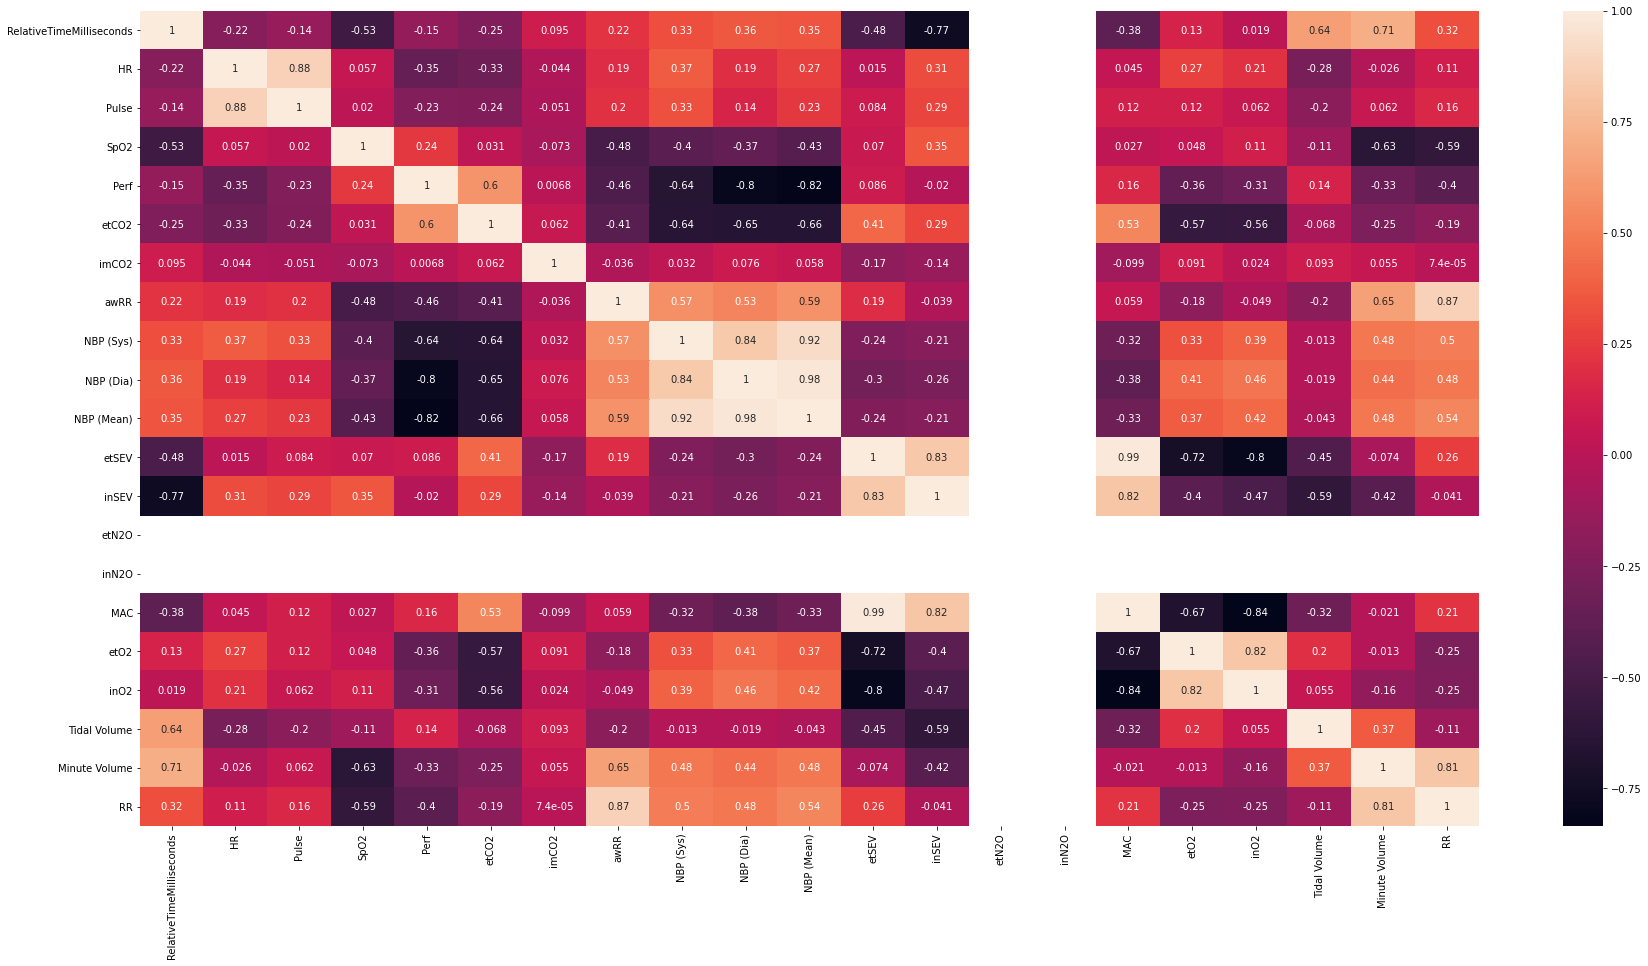

In [17]:
#correlation matrix
cor = df_train.corr()

#plotting heatmap
plt.figure(figsize=(30,15))
sns.heatmap(cor, annot = True)